# Some topic

In [1]:
import datetime
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the random seed
random.seed(42)

We start by loading the data and inspecting the shape and columns.

In [2]:
df_full = pd.read_parquet('data/ml_dataset_full.parquet')

In [3]:
print(df_full.shape)
print(df_full.columns)

(53700, 1009)
Index(['voltage_0', 'voltage_1', 'voltage_2', 'voltage_3', 'voltage_4',
       'voltage_5', 'voltage_6', 'voltage_7', 'voltage_8', 'voltage_9',
       ...
       'current_499', 'sensor_0', 'sensor_1', 'sensor_2', 'sensor_3',
       'sensor_4', 'sensor_5', 'device_id', 'timestamp', 'label'],
      dtype='object', length=1009)


We rearrange the voltage and current columns so that the maximum voltage observation is always in the first column.

In [4]:
voltage, current = df_full.iloc[:, :500].astype(float), df_full.iloc[:, 500:1000].astype(float)

for i in range(len(voltage)):
    shift = np.argmax(voltage.iloc[i])
    voltage.iloc[i] = np.roll(voltage.iloc[i], -shift)
    current.iloc[i] = np.roll(current.iloc[i], -shift)

df_full.iloc[:, :500] = voltage
df_full.iloc[:, 500:1000] = current

We plot some of the data to inspect that the sorting was carried out correctly.

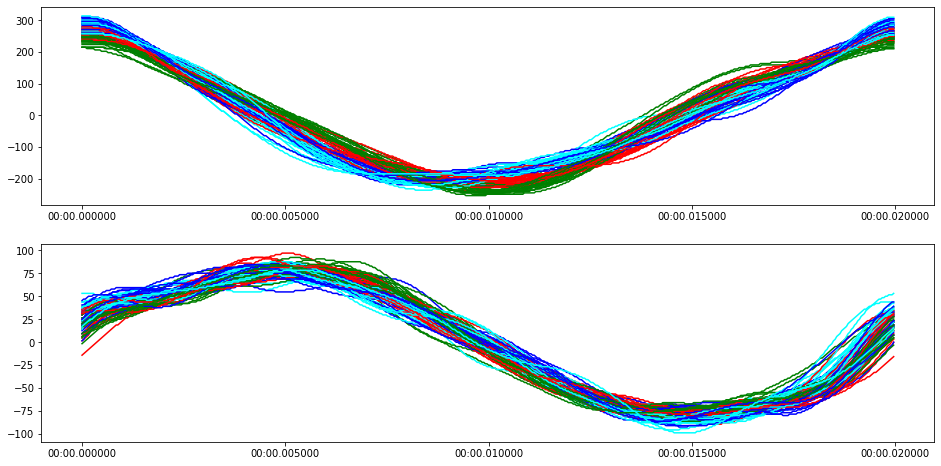

In [5]:
f = plt.figure(figsize=(16, 8))
ax1 = f.add_subplot(2, 1, 1)
ax2 = f.add_subplot(2, 1, 2)

r = 20

for i in range(r):
    for label in [1, 2, 3, 4]:
        df_plot = df_full[df_full.label == label].reset_index(drop=True)
        voltage, current = df_plot.iloc[i, :500].astype(float), df_plot.iloc[i, 500:1000].astype(float)
        
        shift = np.argmax(voltage)
        voltage = np.roll(voltage, (-1) * shift)
        current = np.roll(current, (-1) * shift)
        
        start = datetime.datetime(2000, 1, 1)
        timestamp = np.arange(start, start + datetime.timedelta(microseconds=40 * 500), datetime.timedelta(microseconds=40))
        
        if label == 1:
            ax1.plot(timestamp, voltage, c='red')
            ax2.plot(timestamp, current, c='red')
        if label == 2:
            ax1.plot(timestamp, voltage, c='blue')
            ax2.plot(timestamp, current, c='blue')
        if label == 3:
            ax1.plot(timestamp, voltage, c='green')
            ax2.plot(timestamp, current, c='green')
        if label == 4:
            ax1.plot(timestamp, voltage, c='cyan')
            ax2.plot(timestamp, current, c='cyan')

plt.show()

We create a separate dataframe which only contains labeled data: df_labeled

In [6]:
df_labeled = df_full.dropna(subset=['label']).reset_index(drop=True)

In [7]:
df_labeled.label.value_counts(dropna=False)

1.0    2110
3.0    1110
4.0    1100
2.0    1050
Name: label, dtype: int64

We note that label 1 is the most common label. We investigate the sensor data in relation to the labels.

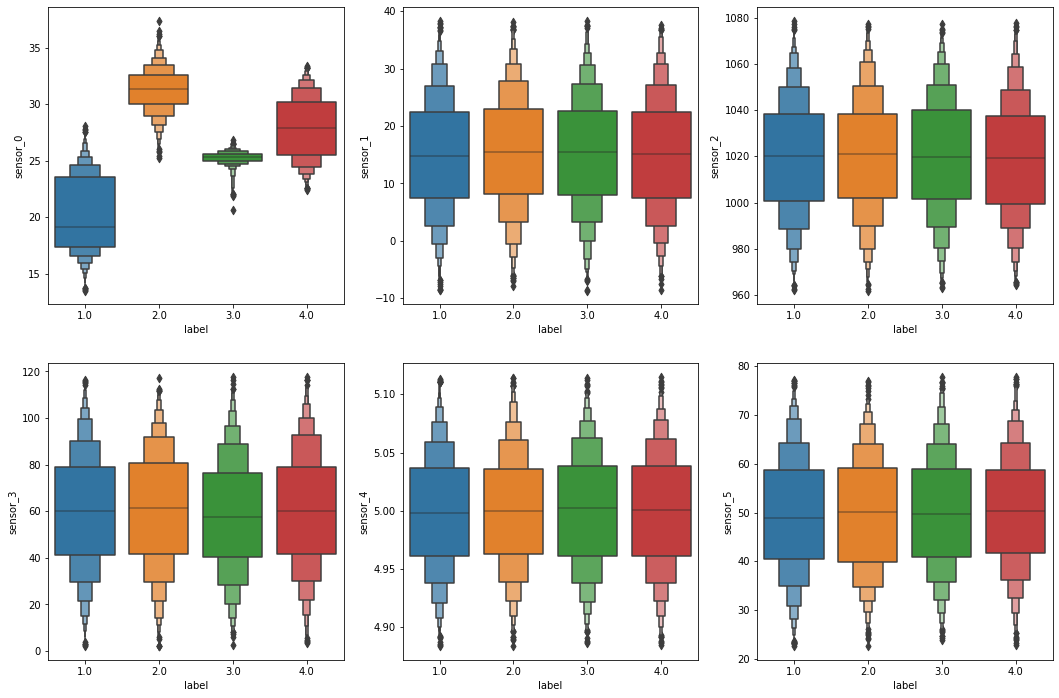

In [8]:
f = plt.figure(figsize=(18, 12))

dataframe = df_labeled

ax1 = f.add_subplot(2, 3, 1)
ax1 = sns.boxenplot(x='label', y='sensor_0', data=dataframe)

ax2 = f.add_subplot(2, 3, 2)
ax2 = sns.boxenplot(x='label', y='sensor_1', data=dataframe)

ax3 = f.add_subplot(2, 3, 3)
ax3 = sns.boxenplot(x='label', y='sensor_2', data=dataframe)

ax4 = f.add_subplot(2, 3, 4)
ax4 = sns.boxenplot(x='label', y='sensor_3', data=dataframe)

ax5 = f.add_subplot(2, 3, 5)
ax5 = sns.boxenplot(x='label', y='sensor_4', data=dataframe)

ax6 = f.add_subplot(2, 3, 6)
ax6 = sns.boxenplot(x='label', y='sensor_5', data=dataframe)

plt.show()

Based on a quick visual inspection, we note that sensor_0 probably contains some valuable information for our use case. It should therefore most likely be included in the model.

As for the other sensors, they don't seem to carry any useful information in this case. We drop them from the dataset.

In [9]:
df_modeling = df_labeled.drop(columns=[f'sensor_{i}' for i in range(1, 6)]).reset_index(drop=True)

We turn our attention to missing data.

In [10]:
df_modeling.dropna().shape[0] / df_modeling.shape[0]

0.9681564245810056

In our modeling dataset, about 97% of the rows do not have any missing data. As the proportion of rows with missing data is low, we drop the 3% with missing data.

In [11]:
df_modeling = df_modeling.dropna().reset_index(drop=True)

In [12]:
df_modeling.shape[0]

5199

In [13]:
df_modeling.label.value_counts(dropna=False)

1.0    2044
3.0    1075
4.0    1065
2.0    1015
Name: label, dtype: int64

# Modeling

In [14]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler  # LabelBinarizer

from scipy.fft import fft

In [15]:
X = df_modeling.drop(columns=['device_id', 'timestamp', 'label'])
y = df_modeling.label
# y = LabelBinarizer().fit_transform(df_modeling.label)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [18]:
gradient_boosting = OneVsRestClassifier(GradientBoostingClassifier())
logistic_regression = LogisticRegression(solver='saga')
random_forest = OneVsRestClassifier(RandomForestClassifier())

In [19]:
gradient_boosting.fit(X_train, y_train)
logistic_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

/Users/carl.mattsson/.pyenv/versions/pdn-monitoring/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


OneVsRestClassifier(estimator=RandomForestClassifier())

In [20]:
y_pred_gb = gradient_boosting.predict(X_test)
y_pred_lr = logistic_regression.predict(X_test)
y_pred_rf = random_forest.predict(X_test)

In [21]:
print('--- Gradient Boosting ---')
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(f"F1 (weighted): {f1_score(y_test, y_pred_gb, average='weighted')}")
print(f"F1 (micro): {f1_score(y_test, y_pred_gb, average='micro')}")
print(f"F1 (macro): {f1_score(y_test, y_pred_gb, average='macro')}")
print('')
print('--- Logistic Regression ---')
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"F1 (weighted): {f1_score(y_test, y_pred_lr, average='weighted')}")
print(f"F1 (micro): {f1_score(y_test, y_pred_lr, average='micro')}")
print(f"F1 (macro): {f1_score(y_test, y_pred_lr, average='macro')}")
print('')
print('--- Random Forest ---')
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"F1 (weighted): {f1_score(y_test, y_pred_rf, average='weighted')}")
print(f"F1 (micro): {f1_score(y_test, y_pred_rf, average='micro')}")
print(f"F1 (macro): {f1_score(y_test, y_pred_rf, average='macro')}")

--- Gradient Boosting ---
Accuracy: 0.96
F1 (weighted): 0.9600473508355178
F1 (micro): 0.96
F1 (macro): 0.9550993193054559

--- Logistic Regression ---
Accuracy: 0.9646153846153847
F1 (weighted): 0.9646062964585681
F1 (micro): 0.9646153846153847
F1 (macro): 0.9598732231321482

--- Random Forest ---
Accuracy: 0.953076923076923
F1 (weighted): 0.9530380949342424
F1 (micro): 0.953076923076923
F1 (macro): 0.945453720610137


# Using Fourier Transform

In [22]:
X = df_modeling.drop(columns=['device_id', 'timestamp', 'label'])
y = df_modeling.label

In [23]:
X.iloc[:, :500] = np.real(fft(X.iloc[:, :500])) / 500
X.iloc[:, 500:1000] = np.real(fft(X.iloc[:, 500:1000])) / 500

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [25]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
gradient_boosting = OneVsRestClassifier(GradientBoostingClassifier())
logistic_regression = LogisticRegression(solver='saga')
random_forest = OneVsRestClassifier(RandomForestClassifier())

In [27]:
gradient_boosting.fit(X_train, y_train)
print('Gradient boosting model trained')
logistic_regression.fit(X_train, y_train)
print('Logistic regression model trained')
random_forest.fit(X_train, y_train)
print('Random forest model trained')

Gradient boosting model trained


/Users/carl.mattsson/.pyenv/versions/pdn-monitoring/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Logistic regression model trained
Random forest model trained


In [28]:
y_pred_gb = gradient_boosting.predict(X_test)
y_pred_lr = logistic_regression.predict(X_test)
y_pred_rf = random_forest.predict(X_test)

In [39]:
print('--- Gradient Boosting ---')
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print('')
print('--- Logistic Regression ---')
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print('')
print('--- Random Forest ---')
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

--- Gradient Boosting ---
Accuracy: 0.9723076923076923

--- Logistic Regression ---
Accuracy: 0.8884615384615384

--- Random Forest ---
Accuracy: 0.9538461538461539


# Using Fourier Transform 2

In [31]:
X = df_modeling.drop(columns=['device_id', 'timestamp', 'label'])
y = df_modeling.label

In [32]:
X.iloc[:, :500] = np.real(fft(X.iloc[:, :500]))
X.iloc[:, 500:1000] = np.real(fft(X.iloc[:, 500:1000]))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [34]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [35]:
gradient_boosting = OneVsRestClassifier(GradientBoostingClassifier())
logistic_regression = LogisticRegression(solver='saga')
random_forest = OneVsRestClassifier(RandomForestClassifier())

In [36]:
gradient_boosting.fit(X_train, y_train)
print('Gradient boosting model trained')
logistic_regression.fit(X_train, y_train)
print('Logistic regression model trained')
random_forest.fit(X_train, y_train)
print('Random forest model trained')

Gradient boosting model trained


/Users/carl.mattsson/.pyenv/versions/pdn-monitoring/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Logistic regression model trained
Random forest model trained


In [37]:
y_pred_gb = gradient_boosting.predict(X_test)
y_pred_lr = logistic_regression.predict(X_test)
y_pred_rf = random_forest.predict(X_test)

In [38]:
print('--- Gradient Boosting ---')
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(f"F1 (weighted): {f1_score(y_test, y_pred_gb, average='weighted')}")
print(f"F1 (micro): {f1_score(y_test, y_pred_gb, average='micro')}")
print(f"F1 (macro): {f1_score(y_test, y_pred_gb, average='macro')}")
print('')
print('--- Logistic Regression ---')
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"F1 (weighted): {f1_score(y_test, y_pred_lr, average='weighted')}")
print(f"F1 (micro): {f1_score(y_test, y_pred_lr, average='micro')}")
print(f"F1 (macro): {f1_score(y_test, y_pred_lr, average='macro')}")
print('')
print('--- Random Forest ---')
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"F1 (weighted): {f1_score(y_test, y_pred_rf, average='weighted')}")
print(f"F1 (micro): {f1_score(y_test, y_pred_rf, average='micro')}")
print(f"F1 (macro): {f1_score(y_test, y_pred_rf, average='macro')}")
#print(f"F1 (samples): {f1_score(y_test, y_pred_rf, average='samples')}")

--- Gradient Boosting ---
Accuracy: 0.9723076923076923
F1 (weighted): 0.9722362809808867
F1 (micro): 0.9723076923076923
F1 (macro): 0.9691320544727341

--- Logistic Regression ---
Accuracy: 0.8884615384615384
F1 (weighted): 0.8888795916618292
F1 (micro): 0.8884615384615383
F1 (macro): 0.8767706980575256

--- Random Forest ---
Accuracy: 0.9538461538461539
F1 (weighted): 0.9535958721238177
F1 (micro): 0.9538461538461539
F1 (macro): 0.9463567551747208


In [ ]:
from scipy.fft import fft, fftfreq

plt.rcParams["figure.figsize"] = (6, 6)

N = 600
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [ ]:
N = 500
T = 1 / 50
x = np.linspace(0.0, N*T, N, endpoint=False)
y = df_modeling.iloc[1000, :500].values
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [ ]:
np.real(yf)

In [ ]:
plt.plot(y)

In [ ]:
df_modeling.iloc[0, :500].plot()

In [ ]:
yf = fft(df_modeling.iloc[0, :500].values)
xf = fftfreq(df_modeling.iloc[0, :500].count(), 1 / 50)
N = 1000
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [ ]:
plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
df_modeling.iloc[0, :500].count()